# Demo of the BGTM on 2-Dimensional Joe-Copula

In this demonstration we show how the GTM can be used to learn a probability distribution from synthetic data sampled from a 2 dimensional Joe copula.
To sample synthetic copula data we use the [pyvinecopulib](https://github.com/vinecopulib/pyvinecopulib) library.
Fore more details on copulas we refer to the Book [Analyzing Dependent Data with Vine Copulas](https://link.springer.com/book/10.1007/978-3-030-13785-4) for an comprehensive introduction to copulas and vine copulas.

In [1]:
from gtm import *

# Sample Copulas Package
import pyvinecopulib as pv

# Other Stuff
import numpy as np
import torch
from torch.utils.data import DataLoader
from dataset_helpers import Generic_Dataset

/Users/franciscocapunay/miniforge3/envs/gtm-general/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 1. Sample Synthetic Copula Data and Compute Likelihoods

We sample data from a Joe Copula and add Gaussian marginals. Feel free to exchange the copula parameter, the rotation or even the copula itsself.
The list of copulas can be found with `help(pv.Bicop)`.

Notice we use Sklars Theorem to compute the density of the joint copula and Gaussian marginals density.

In [2]:
copula_pv = pv.Bicop(family=pv.BicopFamily.joe, parameters=np.array([[2.5]]), rotation=90)

# Train
N_train = 2000
simulated_data_uniform_train = copula_pv.simulate(n=N_train)
simulated_data_train = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_train)).float()

# Validate
N_validate = 2000
simulated_data_uniform_validate = copula_pv.simulate(n=N_validate)
simulated_data_validate = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_validate)).float()

# Test
N_test = 20000
simulated_data_uniform_test = copula_pv.simulate(n=N_test)
simulated_data_test = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_test)).float()

In [3]:
loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_train)).sum(1)
loglik_true_train = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_validate))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_validate)).sum(1)
loglik_true_validate = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_test)).sum(1)
loglik_true_test = torch.tensor(loglik_copula) + log_marginals

/var/folders/_p/ttn2qcdj23jdpltyffhwq9pr0000gn/T/ipykernel_42712/2085715786.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_train)).sum(1)
/var/folders/_p/ttn2qcdj23jdpltyffhwq9pr0000gn/T/ipykernel_42712/2085715786.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_validate)).sum(1)
/var/folders/_p/ttn2qcdj23jdpltyffhwq9pr0000gn/T/ipykernel_42712/2085715786.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True)

We further estimate the copula on the synthetic data to get an oracle denisity estimator. Hence an estimator that knows the true underlying structure and merely estiamtes the model parameters.

In [4]:
copula_pv_est = pv.Bicop(family=pv.BicopFamily.joe, rotation=90)
copula_pv_est.fit(simulated_data_uniform_train)
means = simulated_data_train.mean(0)
vars = simulated_data_train.var(0)

In [5]:
loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_train).sum(1)
loglik_true_est_train = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_validate))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_validate).sum(1)
loglik_true_est_validate = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_test).sum(1)
loglik_true_est_test = torch.tensor(loglik_copula) + log_marginals

The package is implemented to use Dataloaders for training. This is done to accommodate larger datasets trained batch wise as is common in deep learning and bioinformatics applications. Feel free to use the [`Generic_Dataset`](demos/dataset_helpers.py) class to easily adjust it to your data. For full data training, thus whithout batches simply seet the `batch_size` arguement in the `DataLoader` to the data size as we do in this example

In [6]:
# Create dataset and DataLoader
dataset_train = Generic_Dataset(simulated_data_train)
dataloader_train = DataLoader(dataset_train, batch_size=N_train)

dataset_validate = Generic_Dataset(simulated_data_validate)
dataloader_validate = DataLoader(dataset_validate, batch_size=N_validate)

### 2. Define Model

We define a simple GTM model with the standard parameters.
Notable custamizable parameter are: 
- The dimensionality of the data `number_variables`
- The number of transformation layers `num_trans_layers`, either 0 or 1.
- The number of decorrelation layers `num_decorr_layers`, typically 3 or more. 
- the spline to use for the transformation layer splines `spline_transformation` and the decorrelation layer splines `spline_decorrelation`.  The two types of layers: P-Splines (`bspline`) or bernstein polynomials (`bernstein`).
- The degrees of the splines, representing there flexibility, being `degree_decorrelation` for the decorrelation layer splines and `degree_transformations` for the transformation layer. When using `bspline`, then `degree_transformations` can also be given a list with varying degrees for each dimension of the data.
- `transformation_spline_range`sets the outer borders for the transformation layer splines, this dependends on the input data and should be set a bit wider then the actual data.
- `device` either `cpu`or `cuda`


In [7]:
hyperparameters = {
    "transformation": {
    "sigma_a": 2.1, "sigma_b": 1e6,        #Ignored not used
    "RW2": { "tau_a": 1.2, "tau_b": 0.7 },  #E[λ_T] = sehr groß  (smooth but not stiff)
    "RW1": { "tau_a": 10.0,"tau_b": 15.0 }  #Ignored not used
    },
    "decorrelation": {
    "sigma_a": 2.1, "sigma_b": -1e6,              # mean σ² = very small close to 0 (weak)
    "RW2": { "tau_a": 1.5, "tau_b": 0.01 },      # E[κ2] ≈ 0.05   (weak curvature smoothing)
    "RW1": { "tau_a": 1.5, "tau_b": 0.01 },      # E[κ1] ≈ 0.10   (light shrink to linear)
    }
}



model = GTM(
    number_variables=2,
    number_transformation_layers=1,
    number_decorrelation_layers=3,
    degree_transformations=10,
    degree_decorrelation=40,
    spline_transformation="bspline",
    spline_decorrelation="bspline",
    transformation_spline_range=(-10, 10),
    device="cpu",
    ## NEW ARGUMENTS ##
    inference = 'bayesian',
    hyperparameter=hyperparameters
    )


device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
_=model

The GTM class contains a number of plotting functions so that standard analysis can be done soley with the model:

### 3. Hyperparameter Tune and Train Model

To find the optimal penalties one uses the `hyperparameter_tune_penalties` function. Then using the optimal penalties one can train the model.

The training can be done by pretraining the marginal transformations with `pretrain_tranformation_layer` and then training jointly with `train`.
In general empirically we found that pretraining reduces training time and improves results allthough direct joint training also works.

Hyperparameter tuning can be done for the penalties `penvalueridge, penfirstridge , pensecondridge, ctm_pensecondridge, lambda_penalty_params` by passing the arguement `"sample"`.
If a fixed number is passed, typically zero, then for that penalty no hyperparameter drawing is done and the fixed values is used.


In [ ]:
output = model.train(
                train_dataloader=dataloader_train,
                validate_dataloader=dataloader_validate,
                hyperparameters=None,
                iterations=1000,
                #verbose=True,
                learning_rate=0.01,
                mcmc_sample_train=8,            # will ramp
                mcmc_sample_val=32,             # fixed & larger for stable eval
                mc_ramp_every=10,               # 4→8→16→32 at epochs 25/50/75
                mc_ramp_max=64,
                patience=15,                # early-stop patience
                min_delta=0.001,                # ~0.1% absolute of your loss scale
                rho_lr_multiplier=2,          # slightly faster variance adaption (optional)
                sched_factor=0.5, sched_patience=6, sched_threshold=1e-4,
            )

/Users/franciscocapunay/miniforge3/envs/gtm-general/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
  0%|          | 0/1000 [00:00<?, ?it/s]/Users/franciscocapunay/Documents/AkademischeAusbildungLernunterlagen/UniversitaetGoettingen/Studiengänge/MasterAngewandteStatistik/4.Semester/MA/code/gtm/gtm/gtm_splines/bspline_prediction_vectorized.py:595: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3641.)
  x=input_a_clone.T, t=knots.T, c=params_a.T, p=or

[1/1000] train=235.2382  val=235.4406  S_train=8 S_val=32 lr=[0.01, 0.02]σ̄=0.0510  σmin=0.0510  σmax=0.0510


  0%|          | 2/1000 [00:01<11:38,  1.43it/s]

[2/1000] train=232.7592  val=232.5106  S_train=8 S_val=32 lr=[0.01, 0.02]σ̄=0.0520  σmin=0.0520  σmax=0.0520


  0%|          | 3/1000 [00:01<10:41,  1.55it/s]

[3/1000] train=226.7981  val=229.5819  S_train=8 S_val=32 lr=[0.01, 0.02]σ̄=0.0530  σmin=0.0530  σmax=0.0530


  0%|          | 4/1000 [00:02<12:18,  1.35it/s]

[4/1000] train=222.7237  val=226.6548  S_train=8 S_val=32 lr=[0.01, 0.02]σ̄=0.0541  σmin=0.0541  σmax=0.0541


  0%|          | 5/1000 [00:03<13:49,  1.20it/s]

[5/1000] train=222.7366  val=223.7299  S_train=8 S_val=32 lr=[0.01, 0.02]σ̄=0.0551  σmin=0.0551  σmax=0.0551


  1%|          | 6/1000 [00:04<13:51,  1.20it/s]

[6/1000] train=223.4558  val=220.8069  S_train=8 S_val=32 lr=[0.01, 0.02]σ̄=0.0562  σmin=0.0562  σmax=0.0562


  1%|          | 7/1000 [00:05<13:51,  1.19it/s]

[7/1000] train=216.9103  val=217.8860  S_train=8 S_val=32 lr=[0.01, 0.02]σ̄=0.0573  σmin=0.0573  σmax=0.0573


  1%|          | 8/1000 [00:06<14:16,  1.16it/s]

[8/1000] train=217.0481  val=214.9673  S_train=8 S_val=32 lr=[0.01, 0.02]σ̄=0.0584  σmin=0.0584  σmax=0.0584


  1%|          | 9/1000 [00:07<14:15,  1.16it/s]

[9/1000] train=213.8171  val=212.0507  S_train=8 S_val=32 lr=[0.01, 0.02]σ̄=0.0596  σmin=0.0596  σmax=0.0596


  1%|          | 10/1000 [00:08<13:58,  1.18it/s]

[10/1000] train=207.0112  val=209.1362  S_train=8 S_val=32 lr=[0.01, 0.02]σ̄=0.0607  σmin=0.0607  σmax=0.0607


  1%|          | 11/1000 [00:09<16:38,  1.01s/it]

[11/1000] train=211.3541  val=206.2235  S_train=16 S_val=32 lr=[0.01, 0.02]σ̄=0.0619  σmin=0.0619  σmax=0.0619


  1%|          | 12/1000 [00:10<15:06,  1.09it/s]

[12/1000] train=207.6198  val=203.3126  S_train=16 S_val=32 lr=[0.01, 0.02]σ̄=0.0631  σmin=0.0631  σmax=0.0631


  1%|▏         | 13/1000 [00:10<13:58,  1.18it/s]

[13/1000] train=203.6245  val=200.4038  S_train=16 S_val=32 lr=[0.01, 0.02]σ̄=0.0644  σmin=0.0644  σmax=0.0644


  1%|▏         | 14/1000 [00:11<13:09,  1.25it/s]

[14/1000] train=207.4803  val=197.4975  S_train=16 S_val=32 lr=[0.01, 0.02]σ̄=0.0656  σmin=0.0656  σmax=0.0656


  2%|▏         | 15/1000 [00:12<12:30,  1.31it/s]

[15/1000] train=196.1375  val=194.5929  S_train=16 S_val=32 lr=[0.01, 0.02]σ̄=0.0669  σmin=0.0669  σmax=0.0669


  2%|▏         | 16/1000 [00:13<12:19,  1.33it/s]

[16/1000] train=193.7110  val=191.6897  S_train=16 S_val=32 lr=[0.01, 0.02]σ̄=0.0682  σmin=0.0682  σmax=0.0682


  2%|▏         | 17/1000 [00:13<11:57,  1.37it/s]

[17/1000] train=193.8244  val=188.7884  S_train=16 S_val=32 lr=[0.01, 0.02]σ̄=0.0696  σmin=0.0696  σmax=0.0696


  2%|▏         | 18/1000 [00:14<11:36,  1.41it/s]

[18/1000] train=185.3020  val=185.8894  S_train=16 S_val=32 lr=[0.01, 0.02]σ̄=0.0709  σmin=0.0709  σmax=0.0709


  2%|▏         | 19/1000 [00:15<11:28,  1.42it/s]

[19/1000] train=182.9404  val=182.9927  S_train=16 S_val=32 lr=[0.01, 0.02]σ̄=0.0723  σmin=0.0723  σmax=0.0723


  2%|▏         | 20/1000 [00:15<11:35,  1.41it/s]

[20/1000] train=182.8270  val=180.0985  S_train=16 S_val=32 lr=[0.01, 0.02]σ̄=0.0737  σmin=0.0737  σmax=0.0737


  2%|▏         | 21/1000 [00:16<13:14,  1.23it/s]

[21/1000] train=180.0971  val=177.2070  S_train=32 S_val=32 lr=[0.01, 0.02]σ̄=0.0751  σmin=0.0751  σmax=0.0751


  2%|▏         | 22/1000 [00:17<14:35,  1.12it/s]

[22/1000] train=177.7532  val=174.3178  S_train=32 S_val=32 lr=[0.01, 0.02]σ̄=0.0766  σmin=0.0766  σmax=0.0766


  2%|▏         | 23/1000 [00:18<15:26,  1.05it/s]

[23/1000] train=173.3553  val=171.4311  S_train=32 S_val=32 lr=[0.01, 0.02]σ̄=0.0781  σmin=0.0781  σmax=0.0781


  2%|▏         | 24/1000 [00:20<15:50,  1.03it/s]

[24/1000] train=168.2955  val=168.5468  S_train=32 S_val=32 lr=[0.01, 0.02]σ̄=0.0796  σmin=0.0796  σmax=0.0796


  2%|▎         | 25/1000 [00:21<15:54,  1.02it/s]

[25/1000] train=168.7445  val=165.6651  S_train=32 S_val=32 lr=[0.01, 0.02]σ̄=0.0811  σmin=0.0811  σmax=0.0812


  3%|▎         | 26/1000 [00:22<16:21,  1.01s/it]

[26/1000] train=163.7390  val=162.7858  S_train=32 S_val=32 lr=[0.01, 0.02]σ̄=0.0827  σmin=0.0827  σmax=0.0827


  3%|▎         | 27/1000 [00:23<16:35,  1.02s/it]

[27/1000] train=161.6278  val=159.9088  S_train=32 S_val=32 lr=[0.01, 0.02]σ̄=0.0843  σmin=0.0843  σmax=0.0843


  3%|▎         | 28/1000 [00:24<16:38,  1.03s/it]

[28/1000] train=159.2695  val=157.0343  S_train=32 S_val=32 lr=[0.01, 0.02]σ̄=0.0860  σmin=0.0860  σmax=0.0860


  3%|▎         | 29/1000 [00:25<16:29,  1.02s/it]

[29/1000] train=153.1848  val=154.1618  S_train=32 S_val=32 lr=[0.01, 0.02]σ̄=0.0876  σmin=0.0876  σmax=0.0876


  3%|▎         | 30/1000 [00:26<16:58,  1.05s/it]

[30/1000] train=154.9055  val=151.2916  S_train=32 S_val=32 lr=[0.01, 0.02]σ̄=0.0893  σmin=0.0893  σmax=0.0893


  3%|▎         | 31/1000 [00:28<20:16,  1.26s/it]

[31/1000] train=150.4030  val=148.4238  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.0910  σmin=0.0910  σmax=0.0910


  3%|▎         | 32/1000 [00:29<22:34,  1.40s/it]

[32/1000] train=149.9705  val=145.5587  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.0928  σmin=0.0928  σmax=0.0928


  3%|▎         | 33/1000 [00:31<24:39,  1.53s/it]

[33/1000] train=145.2733  val=142.6965  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.0946  σmin=0.0946  σmax=0.0946


  3%|▎         | 34/1000 [00:33<26:21,  1.64s/it]

[34/1000] train=142.4326  val=139.8377  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.0964  σmin=0.0964  σmax=0.0964


  4%|▎         | 35/1000 [00:35<29:11,  1.81s/it]

[35/1000] train=137.6304  val=136.9817  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.0983  σmin=0.0982  σmax=0.0983


  4%|▎         | 36/1000 [00:37<29:13,  1.82s/it]

[36/1000] train=138.7317  val=134.1285  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1001  σmin=0.1001  σmax=0.1002


  4%|▎         | 37/1000 [00:40<32:20,  2.01s/it]

[37/1000] train=134.0181  val=131.2782  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1021  σmin=0.1020  σmax=0.1021


  4%|▍         | 38/1000 [00:42<36:26,  2.27s/it]

[38/1000] train=130.0629  val=128.4309  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1040  σmin=0.1040  σmax=0.1040


  4%|▍         | 39/1000 [00:44<35:02,  2.19s/it]

[39/1000] train=128.6161  val=125.5865  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1060  σmin=0.1060  σmax=0.1060


  4%|▍         | 40/1000 [00:46<32:28,  2.03s/it]

[40/1000] train=124.9093  val=122.7458  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1081  σmin=0.1080  σmax=0.1081


  4%|▍         | 41/1000 [00:48<30:15,  1.89s/it]

[41/1000] train=123.3624  val=119.9088  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1101  σmin=0.1101  σmax=0.1101


  4%|▍         | 42/1000 [00:49<29:19,  1.84s/it]

[42/1000] train=119.1417  val=117.0751  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1122  σmin=0.1122  σmax=0.1122


  4%|▍         | 43/1000 [00:51<29:39,  1.86s/it]

[43/1000] train=116.6903  val=114.2442  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1144  σmin=0.1143  σmax=0.1144


  4%|▍         | 44/1000 [00:54<32:22,  2.03s/it]

[44/1000] train=112.9390  val=111.4163  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1165  σmin=0.1165  σmax=0.1166


  4%|▍         | 45/1000 [00:56<34:26,  2.16s/it]

[45/1000] train=110.8336  val=108.5903  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1188  σmin=0.1187  σmax=0.1188


  5%|▍         | 46/1000 [00:58<34:34,  2.17s/it]

[46/1000] train=109.3654  val=105.7664  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1210  σmin=0.1209  σmax=0.1210


  5%|▍         | 47/1000 [01:01<35:25,  2.23s/it]

[47/1000] train=104.7854  val=102.9461  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1233  σmin=0.1232  σmax=0.1233


  5%|▍         | 48/1000 [01:04<39:05,  2.46s/it]

[48/1000] train=103.1215  val=100.1298  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1257  σmin=0.1256  σmax=0.1257


  5%|▍         | 49/1000 [01:05<35:09,  2.22s/it]

[49/1000] train=100.7319  val=97.3181  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1281  σmin=0.1279  σmax=0.1281


  5%|▌         | 50/1000 [01:07<31:44,  2.00s/it]

[50/1000] train=96.8781  val=94.5102  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1305  σmin=0.1304  σmax=0.1305


  5%|▌         | 51/1000 [01:09<30:01,  1.90s/it]

[51/1000] train=94.9374  val=91.7061  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1329  σmin=0.1328  σmax=0.1330


  5%|▌         | 52/1000 [01:11<30:55,  1.96s/it]

[52/1000] train=90.6635  val=88.9056  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1355  σmin=0.1353  σmax=0.1355


  5%|▌         | 53/1000 [01:12<29:21,  1.86s/it]

[53/1000] train=89.3333  val=86.1092  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1380  σmin=0.1379  σmax=0.1380


  5%|▌         | 54/1000 [01:14<28:30,  1.81s/it]

[54/1000] train=85.9599  val=83.3166  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1406  σmin=0.1405  σmax=0.1407


  6%|▌         | 55/1000 [01:16<29:10,  1.85s/it]

[55/1000] train=82.8506  val=80.5285  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1433  σmin=0.1431  σmax=0.1433


  6%|▌         | 56/1000 [01:18<30:49,  1.96s/it]

[56/1000] train=78.6123  val=77.7441  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1460  σmin=0.1458  σmax=0.1460


  6%|▌         | 57/1000 [01:20<30:45,  1.96s/it]

[57/1000] train=75.1076  val=74.9640  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1487  σmin=0.1485  σmax=0.1487


  6%|▌         | 58/1000 [01:23<34:55,  2.22s/it]

[58/1000] train=75.1096  val=72.1879  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1515  σmin=0.1513  σmax=0.1515


  6%|▌         | 59/1000 [01:25<34:34,  2.20s/it]

[59/1000] train=70.8149  val=69.4146  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1543  σmin=0.1541  σmax=0.1544


  6%|▌         | 60/1000 [01:27<34:03,  2.17s/it]

[60/1000] train=69.2298  val=66.6454  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1572  σmin=0.1570  σmax=0.1573


  6%|▌         | 61/1000 [01:29<33:42,  2.15s/it]

[61/1000] train=63.3871  val=63.8816  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1601  σmin=0.1599  σmax=0.1602


  6%|▌         | 62/1000 [01:32<34:17,  2.19s/it]

[62/1000] train=62.3133  val=61.1231  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1631  σmin=0.1628  σmax=0.1632


  6%|▋         | 63/1000 [01:34<35:42,  2.29s/it]

[63/1000] train=59.8157  val=58.3699  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1662  σmin=0.1659  σmax=0.1662


  6%|▋         | 64/1000 [01:37<39:47,  2.55s/it]

[64/1000] train=57.9552  val=55.6206  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1692  σmin=0.1689  σmax=0.1693


  6%|▋         | 65/1000 [01:41<43:58,  2.82s/it]

[65/1000] train=55.6419  val=52.8746  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1724  σmin=0.1720  σmax=0.1725


  7%|▋         | 66/1000 [01:43<43:27,  2.79s/it]

[66/1000] train=52.5377  val=50.1321  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1756  σmin=0.1752  σmax=0.1757


  7%|▋         | 67/1000 [01:45<38:45,  2.49s/it]

[67/1000] train=49.9303  val=47.3956  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1788  σmin=0.1784  σmax=0.1789


  7%|▋         | 68/1000 [01:47<36:47,  2.37s/it]

[68/1000] train=48.1489  val=44.6639  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1821  σmin=0.1817  σmax=0.1822


  7%|▋         | 69/1000 [01:50<37:01,  2.39s/it]

[69/1000] train=43.0058  val=41.9375  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1855  σmin=0.1850  σmax=0.1856


  7%|▋         | 70/1000 [01:52<35:00,  2.26s/it]

[70/1000] train=40.5285  val=39.2161  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1889  σmin=0.1884  σmax=0.1890


  7%|▋         | 71/1000 [01:54<33:37,  2.17s/it]

[71/1000] train=37.6138  val=36.4999  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1924  σmin=0.1919  σmax=0.1925


  7%|▋         | 72/1000 [01:55<31:29,  2.04s/it]

[72/1000] train=37.3893  val=33.7897  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1959  σmin=0.1953  σmax=0.1961


  7%|▋         | 73/1000 [01:57<31:25,  2.03s/it]

[73/1000] train=32.9825  val=31.0863  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1995  σmin=0.1989  σmax=0.1997


  7%|▋         | 74/1000 [02:02<41:21,  2.68s/it]

[74/1000] train=30.9238  val=28.3900  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.2031  σmin=0.2025  σmax=0.2033


  8%|▊         | 75/1000 [02:03<37:49,  2.45s/it]

[75/1000] train=28.3335  val=25.6967  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.2068  σmin=0.2061  σmax=0.2070


  8%|▊         | 76/1000 [02:05<34:53,  2.27s/it]

[76/1000] train=23.3988  val=23.0096  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.2106  σmin=0.2099  σmax=0.2108


  8%|▊         | 77/1000 [02:07<32:33,  2.12s/it]

[77/1000] train=24.2048  val=20.3269  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.2144  σmin=0.2136  σmax=0.2147


  8%|▊         | 78/1000 [02:09<31:44,  2.07s/it]

[78/1000] train=20.8655  val=17.6482  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.2183  σmin=0.2175  σmax=0.2186


  8%|▊         | 79/1000 [02:11<30:37,  1.99s/it]

[79/1000] train=16.0059  val=14.9727  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.2223  σmin=0.2214  σmax=0.2225


  8%|▊         | 80/1000 [02:13<30:20,  1.98s/it]

[80/1000] train=14.7102  val=12.3027  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.2263  σmin=0.2253  σmax=0.2266


  8%|▊         | 81/1000 [02:16<34:57,  2.28s/it]

[81/1000] train=10.6317  val=9.6407  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.2304  σmin=0.2293  σmax=0.2307


  8%|▊         | 82/1000 [02:19<38:37,  2.52s/it]

[82/1000] train=8.0470  val=6.9868  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.2345  σmin=0.2334  σmax=0.2349


  8%|▊         | 83/1000 [02:21<37:04,  2.43s/it]

[83/1000] train=7.1662  val=4.3404  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.2387  σmin=0.2375  σmax=0.2391


  8%|▊         | 84/1000 [02:23<36:53,  2.42s/it]

[84/1000] train=3.1969  val=1.7002  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.2430  σmin=0.2417  σmax=0.2434


  8%|▊         | 85/1000 [02:26<37:45,  2.48s/it]

[85/1000] train=1.5468  val=-0.9338  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.2474  σmin=0.2460  σmax=0.2478


  9%|▊         | 86/1000 [02:28<36:16,  2.38s/it]

[86/1000] train=-3.1112  val=-3.5610  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.2518  σmin=0.2503  σmax=0.2522


  9%|▊         | 87/1000 [02:30<34:10,  2.25s/it]

[87/1000] train=-5.1028  val=-6.1810  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.2563  σmin=0.2547  σmax=0.2567


  9%|▉         | 88/1000 [02:32<33:35,  2.21s/it]

[88/1000] train=-7.9344  val=-8.7932  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.2608  σmin=0.2592  σmax=0.2613


  9%|▉         | 89/1000 [02:34<33:12,  2.19s/it]

[89/1000] train=-8.3437  val=-11.3993  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.2655  σmin=0.2637  σmax=0.2660


  9%|▉         | 90/1000 [02:37<32:55,  2.17s/it]

[90/1000] train=-13.5829  val=-13.9988  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.2702  σmin=0.2683  σmax=0.2707


  9%|▉         | 91/1000 [02:39<33:49,  2.23s/it]

[91/1000] train=-14.6392  val=-16.5931  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.2749  σmin=0.2729  σmax=0.2755


  9%|▉         | 92/1000 [02:41<32:34,  2.15s/it]

[92/1000] train=-16.7144  val=-19.1818  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.2798  σmin=0.2777  σmax=0.2804


  9%|▉         | 93/1000 [02:43<30:41,  2.03s/it]

[93/1000] train=-20.1061  val=-21.7630  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.2847  σmin=0.2825  σmax=0.2853


  9%|▉         | 94/1000 [02:45<31:14,  2.07s/it]

[94/1000] train=-20.7591  val=-24.3388  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.2897  σmin=0.2873  σmax=0.2904


 10%|▉         | 95/1000 [02:47<33:20,  2.21s/it]

[95/1000] train=-26.0201  val=-26.9075  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.2947  σmin=0.2922  σmax=0.2955


 10%|▉         | 96/1000 [02:50<33:04,  2.20s/it]

[96/1000] train=-26.7571  val=-29.4699  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.2999  σmin=0.2972  σmax=0.3007


 10%|▉         | 97/1000 [02:52<32:51,  2.18s/it]

[97/1000] train=-29.1082  val=-32.0237  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.3051  σmin=0.3023  σmax=0.3059


 10%|▉         | 98/1000 [02:53<30:48,  2.05s/it]

[98/1000] train=-32.8302  val=-34.5696  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.3104  σmin=0.3074  σmax=0.3113


 10%|▉         | 99/1000 [02:55<29:11,  1.94s/it]

[99/1000] train=-33.9116  val=-37.1075  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.3158  σmin=0.3126  σmax=0.3167


 10%|█         | 100/1000 [02:57<28:18,  1.89s/it]

[100/1000] train=-37.5487  val=-39.6360  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.3212  σmin=0.3179  σmax=0.3222


 10%|█         | 101/1000 [03:00<32:04,  2.14s/it]

[101/1000] train=-40.3885  val=-42.1549  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.3268  σmin=0.3233  σmax=0.3278


 10%|█         | 102/1000 [03:03<36:32,  2.44s/it]

[102/1000] train=-42.0073  val=-44.6629  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.3324  σmin=0.3287  σmax=0.3335


 10%|█         | 103/1000 [03:05<33:42,  2.25s/it]

[103/1000] train=-45.2704  val=-47.1635  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.3381  σmin=0.3342  σmax=0.3393


 10%|█         | 104/1000 [03:06<30:45,  2.06s/it]

[104/1000] train=-46.6841  val=-49.6584  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.3439  σmin=0.3397  σmax=0.3451


 10%|█         | 105/1000 [03:08<28:39,  1.92s/it]

[105/1000] train=-51.1684  val=-52.1450  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.3497  σmin=0.3453  σmax=0.3511


 11%|█         | 106/1000 [03:09<27:19,  1.83s/it]

[106/1000] train=-53.6580  val=-54.6220  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.3557  σmin=0.3510  σmax=0.3571


 11%|█         | 107/1000 [03:11<27:00,  1.81s/it]

[107/1000] train=-54.8865  val=-57.0893  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.3617  σmin=0.3568  σmax=0.3632


 11%|█         | 108/1000 [03:13<27:30,  1.85s/it]

[108/1000] train=-58.6865  val=-59.5482  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.3678  σmin=0.3626  σmax=0.3694


 11%|█         | 109/1000 [03:15<26:23,  1.78s/it]

[109/1000] train=-60.1710  val=-61.9991  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.3740  σmin=0.3685  σmax=0.3757


 11%|█         | 110/1000 [03:16<25:39,  1.73s/it]

[110/1000] train=-61.8237  val=-64.4392  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.3803  σmin=0.3745  σmax=0.3821


 11%|█         | 111/1000 [03:18<25:19,  1.71s/it]

[111/1000] train=-63.8081  val=-66.8687  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.3866  σmin=0.3805  σmax=0.3885


 11%|█         | 112/1000 [03:20<24:45,  1.67s/it]

[112/1000] train=-66.9743  val=-69.2870  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.3931  σmin=0.3866  σmax=0.3951


 11%|█▏        | 113/1000 [03:21<24:52,  1.68s/it]

[113/1000] train=-69.3177  val=-71.6992  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.3996  σmin=0.3928  σmax=0.4018


 11%|█▏        | 114/1000 [03:23<25:13,  1.71s/it]

[114/1000] train=-71.4675  val=-74.1021  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.4063  σmin=0.3991  σmax=0.4085


 12%|█▏        | 115/1000 [03:25<24:43,  1.68s/it]

[115/1000] train=-75.3624  val=-76.4956  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.4130  σmin=0.4055  σmax=0.4154


 12%|█▏        | 116/1000 [03:26<24:31,  1.66s/it]

[116/1000] train=-76.2172  val=-78.8773  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.4198  σmin=0.4119  σmax=0.4223


 12%|█▏        | 117/1000 [03:28<24:59,  1.70s/it]

[117/1000] train=-79.4121  val=-81.2489  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.4267  σmin=0.4185  σmax=0.4293


 12%|█▏        | 118/1000 [03:30<24:24,  1.66s/it]

[118/1000] train=-81.3718  val=-83.6146  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.4337  σmin=0.4251  σmax=0.4365


 12%|█▏        | 119/1000 [03:31<24:06,  1.64s/it]

[119/1000] train=-84.5511  val=-85.9710  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.4408  σmin=0.4318  σmax=0.4437


 12%|█▏        | 120/1000 [03:33<23:45,  1.62s/it]

[120/1000] train=-87.1189  val=-88.3205  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.4480  σmin=0.4385  σmax=0.4510


 12%|█▏        | 121/1000 [03:34<23:38,  1.61s/it]

[121/1000] train=-89.8505  val=-90.6603  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.4552  σmin=0.4454  σmax=0.4585


 12%|█▏        | 122/1000 [03:36<23:56,  1.64s/it]

[122/1000] train=-91.7142  val=-92.9907  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.4626  σmin=0.4523  σmax=0.4660


 12%|█▏        | 123/1000 [03:38<24:35,  1.68s/it]

[123/1000] train=-92.9097  val=-95.3089  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.4700  σmin=0.4593  σmax=0.4736


 12%|█▏        | 124/1000 [03:39<24:12,  1.66s/it]

[124/1000] train=-96.8492  val=-97.6172  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.4776  σmin=0.4663  σmax=0.4814


 12%|█▎        | 125/1000 [03:41<24:26,  1.68s/it]

[125/1000] train=-98.4029  val=-99.9148  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.4852  σmin=0.4734  σmax=0.4892


 13%|█▎        | 126/1000 [03:43<26:20,  1.81s/it]

[126/1000] train=-99.9837  val=-102.1989  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.4929  σmin=0.4805  σmax=0.4972


 13%|█▎        | 127/1000 [03:46<31:19,  2.15s/it]

[127/1000] train=-103.4500  val=-104.4699  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.5008  σmin=0.4877  σmax=0.5052


 13%|█▎        | 128/1000 [03:49<33:08,  2.28s/it]

[128/1000] train=-104.8559  val=-106.7295  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.5087  σmin=0.4949  σmax=0.5134


 13%|█▎        | 129/1000 [03:51<33:58,  2.34s/it]

[129/1000] train=-106.4715  val=-108.9790  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.5167  σmin=0.5021  σmax=0.5216


 13%|█▎        | 130/1000 [03:54<35:19,  2.44s/it]

[130/1000] train=-109.4427  val=-111.2155  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.5248  σmin=0.5095  σmax=0.5300


 13%|█▎        | 131/1000 [04:01<54:07,  3.74s/it]

[131/1000] train=-113.8432  val=-113.4368  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.5330  σmin=0.5170  σmax=0.5385


 13%|█▎        | 132/1000 [04:04<50:02,  3.46s/it]

[132/1000] train=-113.2766  val=-115.6466  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.5413  σmin=0.5245  σmax=0.5471


 13%|█▎        | 133/1000 [04:06<46:12,  3.20s/it]

[133/1000] train=-118.2193  val=-117.8382  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.5497  σmin=0.5319  σmax=0.5558


 13%|█▎        | 134/1000 [04:09<46:21,  3.21s/it]

[134/1000] train=-117.6362  val=-120.0101  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.5582  σmin=0.5395  σmax=0.5646


 14%|█▎        | 135/1000 [04:12<44:55,  3.12s/it]

[135/1000] train=-118.4132  val=-122.1692  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.5668  σmin=0.5471  σmax=0.5735


 14%|█▎        | 136/1000 [04:14<40:28,  2.81s/it]

[136/1000] train=-121.5167  val=-124.3007  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.5755  σmin=0.5548  σmax=0.5825


 14%|█▎        | 137/1000 [04:17<37:47,  2.63s/it]

[137/1000] train=-123.6877  val=-126.4180  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.5843  σmin=0.5625  σmax=0.5917


 14%|█▍        | 138/1000 [04:20<42:17,  2.94s/it]

[138/1000] train=-128.2589  val=-128.5197  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.5932  σmin=0.5703  σmax=0.6010


 14%|█▍        | 139/1000 [04:23<40:10,  2.80s/it]

[139/1000] train=-128.2601  val=-130.6238  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.6022  σmin=0.5780  σmax=0.6103


 14%|█▍        | 140/1000 [04:25<36:59,  2.58s/it]

[140/1000] train=-132.2732  val=-132.7298  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.6112  σmin=0.5856  σmax=0.6198


 14%|█▍        | 141/1000 [04:27<35:07,  2.45s/it]

[141/1000] train=-133.2963  val=-134.8414  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.6204  σmin=0.5934  σmax=0.6294


 14%|█▍        | 142/1000 [04:29<32:55,  2.30s/it]

[142/1000] train=-135.1038  val=-136.9416  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.6297  σmin=0.6013  σmax=0.6391


 14%|█▍        | 143/1000 [04:31<31:23,  2.20s/it]

[143/1000] train=-136.0807  val=-139.0267  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.6390  σmin=0.6093  σmax=0.6490


 14%|█▍        | 144/1000 [04:33<32:13,  2.26s/it]

[144/1000] train=-140.5366  val=-141.1006  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.6485  σmin=0.6174  σmax=0.6589


 14%|█▍        | 145/1000 [04:36<33:52,  2.38s/it]

[145/1000] train=-143.3567  val=-143.1510  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.6581  σmin=0.6254  σmax=0.6690


 15%|█▍        | 146/1000 [04:38<31:29,  2.21s/it]

[146/1000] train=-142.9529  val=-145.1833  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.6678  σmin=0.6332  σmax=0.6792


 15%|█▍        | 147/1000 [04:39<28:42,  2.02s/it]

[147/1000] train=-144.6478  val=-147.1988  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.6775  σmin=0.6410  σmax=0.6896


 15%|█▍        | 148/1000 [04:41<26:40,  1.88s/it]

[148/1000] train=-147.8241  val=-149.2022  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.6874  σmin=0.6488  σmax=0.7000


 15%|█▍        | 149/1000 [04:42<25:13,  1.78s/it]

[149/1000] train=-149.7123  val=-151.1872  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.6974  σmin=0.6567  σmax=0.7106


 15%|█▌        | 150/1000 [04:44<25:15,  1.78s/it]

[150/1000] train=-150.8620  val=-153.1541  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.7074  σmin=0.6647  σmax=0.7213


 15%|█▌        | 151/1000 [04:47<27:29,  1.94s/it]

[151/1000] train=-152.7162  val=-155.1086  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.7176  σmin=0.6727  σmax=0.7321


 15%|█▌        | 152/1000 [04:48<26:47,  1.90s/it]

[152/1000] train=-155.0686  val=-157.0424  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.7279  σmin=0.6805  σmax=0.7431


 15%|█▌        | 153/1000 [04:50<25:52,  1.83s/it]

[153/1000] train=-159.2307  val=-158.9609  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.7382  σmin=0.6882  σmax=0.7542


 15%|█▌        | 154/1000 [04:52<26:21,  1.87s/it]

[154/1000] train=-161.1848  val=-160.8659  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.7487  σmin=0.6960  σmax=0.7654


 16%|█▌        | 155/1000 [04:54<26:34,  1.89s/it]

[155/1000] train=-159.8868  val=-162.7536  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.7592  σmin=0.7038  σmax=0.7768


 16%|█▌        | 156/1000 [04:56<28:35,  2.03s/it]

[156/1000] train=-163.6225  val=-164.6275  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.7698  σmin=0.7116  σmax=0.7883


 16%|█▌        | 157/1000 [04:59<29:37,  2.11s/it]

[157/1000] train=-164.9863  val=-166.4724  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.7806  σmin=0.7196  σmax=0.7999


 16%|█▌        | 158/1000 [05:01<32:16,  2.30s/it]

[158/1000] train=-165.9141  val=-168.3012  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.7914  σmin=0.7277  σmax=0.8116


 16%|█▌        | 159/1000 [05:03<30:43,  2.19s/it]

[159/1000] train=-168.3365  val=-170.1129  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.8023  σmin=0.7355  σmax=0.8235


 16%|█▌        | 160/1000 [05:05<30:10,  2.16s/it]

[160/1000] train=-170.5918  val=-171.9120  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.8133  σmin=0.7429  σmax=0.8355


 16%|█▌        | 161/1000 [05:07<29:11,  2.09s/it]

[161/1000] train=-170.1842  val=-173.7016  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.8244  σmin=0.7504  σmax=0.8477


 16%|█▌        | 162/1000 [05:09<27:49,  1.99s/it]

[162/1000] train=-173.0838  val=-175.4764  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.8356  σmin=0.7566  σmax=0.8599


 16%|█▋        | 163/1000 [05:11<27:17,  1.96s/it]

[163/1000] train=-173.5870  val=-177.2327  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.8468  σmin=0.7628  σmax=0.8723


 16%|█▋        | 164/1000 [05:13<26:26,  1.90s/it]

[164/1000] train=-178.7475  val=-178.9757  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.8582  σmin=0.7688  σmax=0.8849


 16%|█▋        | 165/1000 [05:15<27:06,  1.95s/it]

[165/1000] train=-179.1087  val=-180.6951  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.8696  σmin=0.7752  σmax=0.8975


 17%|█▋        | 166/1000 [05:16<26:08,  1.88s/it]

[166/1000] train=-180.6548  val=-182.3870  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.8811  σmin=0.7819  σmax=0.9104


 17%|█▋        | 167/1000 [05:18<25:56,  1.87s/it]

[167/1000] train=-183.9132  val=-184.0634  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.8928  σmin=0.7887  σmax=0.9233


 17%|█▋        | 168/1000 [05:20<25:06,  1.81s/it]

[168/1000] train=-183.5581  val=-185.7207  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.9045  σmin=0.7958  σmax=0.9364


 17%|█▋        | 169/1000 [05:22<25:26,  1.84s/it]

[169/1000] train=-187.4217  val=-187.3755  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.9162  σmin=0.8024  σmax=0.9497


 17%|█▋        | 170/1000 [05:23<24:36,  1.78s/it]

[170/1000] train=-189.3262  val=-189.0287  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.9280  σmin=0.8087  σmax=0.9630


 17%|█▋        | 171/1000 [05:25<24:35,  1.78s/it]

[171/1000] train=-188.9479  val=-190.6445  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.9399  σmin=0.8156  σmax=0.9765


 17%|█▋        | 172/1000 [05:27<24:28,  1.77s/it]

[172/1000] train=-191.2919  val=-192.2375  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.9519  σmin=0.8224  σmax=0.9902


 17%|█▋        | 173/1000 [05:29<24:11,  1.75s/it]

[173/1000] train=-193.4925  val=-193.8108  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.9638  σmin=0.8280  σmax=1.0039


 17%|█▋        | 174/1000 [05:31<26:07,  1.90s/it]

[174/1000] train=-194.2713  val=-195.3775  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.9758  σmin=0.8335  σmax=1.0178


 18%|█▊        | 175/1000 [05:33<26:38,  1.94s/it]

[175/1000] train=-194.6588  val=-196.9371  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.9878  σmin=0.8392  σmax=1.0318


 18%|█▊        | 176/1000 [05:35<25:44,  1.87s/it]

[176/1000] train=-196.7779  val=-198.4445  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.9999  σmin=0.8455  σmax=1.0459


 18%|█▊        | 177/1000 [05:36<25:14,  1.84s/it]

[177/1000] train=-200.4772  val=-199.9281  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.0120  σmin=0.8489  σmax=1.0600


 18%|█▊        | 178/1000 [05:39<26:07,  1.91s/it]

[178/1000] train=-200.1074  val=-201.3741  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.0240  σmin=0.8575  σmax=1.0741


 18%|█▊        | 179/1000 [05:40<25:38,  1.87s/it]

[179/1000] train=-199.7936  val=-202.7860  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.0361  σmin=0.8659  σmax=1.0883


 18%|█▊        | 180/1000 [05:42<25:24,  1.86s/it]

[180/1000] train=-203.3246  val=-204.1888  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.0482  σmin=0.8711  σmax=1.1027


 18%|█▊        | 181/1000 [05:44<26:22,  1.93s/it]

[181/1000] train=-202.3841  val=-205.5794  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.0603  σmin=0.8776  σmax=1.1171


 18%|█▊        | 182/1000 [05:46<27:27,  2.01s/it]

[182/1000] train=-205.4239  val=-206.9591  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.0725  σmin=0.8843  σmax=1.1317


 18%|█▊        | 183/1000 [05:48<26:46,  1.97s/it]

[183/1000] train=-205.9557  val=-208.3029  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.0847  σmin=0.8890  σmax=1.1464


 18%|█▊        | 184/1000 [05:50<25:22,  1.87s/it]

[184/1000] train=-207.8754  val=-209.5607  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.0966  σmin=0.8942  σmax=1.1610


 18%|█▊        | 185/1000 [05:52<24:22,  1.79s/it]

[185/1000] train=-208.5129  val=-210.8224  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.1085  σmin=0.8979  σmax=1.1756


 19%|█▊        | 186/1000 [05:53<23:31,  1.73s/it]

[186/1000] train=-210.7760  val=-212.0296  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.1205  σmin=0.9016  σmax=1.1905


 19%|█▊        | 187/1000 [05:55<23:30,  1.74s/it]

[187/1000] train=-210.2237  val=-213.2133  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.1322  σmin=0.9023  σmax=1.2052


 19%|█▉        | 188/1000 [05:57<23:21,  1.73s/it]

[188/1000] train=-213.2134  val=-214.2877  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.1438  σmin=0.9032  σmax=1.2198


 19%|█▉        | 189/1000 [05:58<23:27,  1.74s/it]

[189/1000] train=-213.4243  val=-215.4292  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.1555  σmin=0.9055  σmax=1.2346


 19%|█▉        | 190/1000 [06:00<23:41,  1.75s/it]

[190/1000] train=-216.3434  val=-216.5413  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.1674  σmin=0.9062  σmax=1.2497


 19%|█▉        | 191/1000 [06:02<24:02,  1.78s/it]

[191/1000] train=-214.6071  val=-217.5642  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.1794  σmin=0.9090  σmax=1.2649


 19%|█▉        | 192/1000 [06:04<26:03,  1.93s/it]

[192/1000] train=-218.3669  val=-218.7331  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.1915  σmin=0.9101  σmax=1.2804


 19%|█▉        | 193/1000 [06:06<24:56,  1.85s/it]

[193/1000] train=-217.4026  val=-219.8289  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.2037  σmin=0.9132  σmax=1.2960


 19%|█▉        | 194/1000 [06:08<24:52,  1.85s/it]

[194/1000] train=-219.4570  val=-220.8957  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.2159  σmin=0.9182  σmax=1.3116


 20%|█▉        | 195/1000 [06:10<24:53,  1.85s/it]

[195/1000] train=-217.5622  val=-221.9781  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.2280  σmin=0.9225  σmax=1.3274


 20%|█▉        | 196/1000 [06:12<25:10,  1.88s/it]

[196/1000] train=-221.5137  val=-222.9972  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.2395  σmin=0.9238  σmax=1.3423


 20%|█▉        | 197/1000 [06:13<24:36,  1.84s/it]

[197/1000] train=-221.8389  val=-223.9790  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.2510  σmin=0.9252  σmax=1.3574


 20%|█▉        | 198/1000 [06:15<24:48,  1.86s/it]

[198/1000] train=-222.1759  val=-224.8218  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.2626  σmin=0.9265  σmax=1.3727


 20%|█▉        | 199/1000 [06:17<25:51,  1.94s/it]

[199/1000] train=-224.2283  val=-225.7931  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.2737  σmin=0.9265  σmax=1.3877


 20%|██        | 200/1000 [06:20<30:03,  2.25s/it]

[200/1000] train=-227.1578  val=-226.6683  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.2848  σmin=0.9279  σmax=1.4029


 20%|██        | 201/1000 [06:23<30:52,  2.32s/it]

[201/1000] train=-223.3527  val=-227.5175  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.2959  σmin=0.9298  σmax=1.4182


 20%|██        | 202/1000 [06:25<30:38,  2.30s/it]

[202/1000] train=-226.8402  val=-228.3190  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.3065  σmin=0.9275  σmax=1.4331


 20%|██        | 203/1000 [06:28<31:27,  2.37s/it]

[203/1000] train=-227.0443  val=-228.9747  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.3168  σmin=0.9239  σmax=1.4474


 20%|██        | 204/1000 [06:30<32:34,  2.46s/it]

[204/1000] train=-228.7727  val=-229.6561  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.3268  σmin=0.9198  σmax=1.4616


 20%|██        | 205/1000 [06:33<35:22,  2.67s/it]

[205/1000] train=-232.6241  val=-230.3100  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.3367  σmin=0.9146  σmax=1.4759


 21%|██        | 206/1000 [06:36<35:59,  2.72s/it]

[206/1000] train=-230.5292  val=-230.9706  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.3469  σmin=0.9098  σmax=1.4907


 21%|██        | 207/1000 [06:39<34:42,  2.63s/it]

[207/1000] train=-230.0758  val=-231.5670  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.3569  σmin=0.9065  σmax=1.5054


 21%|██        | 208/1000 [06:41<31:44,  2.40s/it]

[208/1000] train=-231.4494  val=-232.1910  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.3668  σmin=0.8982  σmax=1.5200


 21%|██        | 209/1000 [06:43<30:29,  2.31s/it]

[209/1000] train=-233.0410  val=-232.6635  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.3763  σmin=0.8911  σmax=1.5342


 21%|██        | 210/1000 [06:44<28:14,  2.14s/it]

[210/1000] train=-232.3846  val=-233.2015  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.3855  σmin=0.8794  σmax=1.5483


 21%|██        | 211/1000 [06:46<26:18,  2.00s/it]

[211/1000] train=-234.1341  val=-233.7823  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.3950  σmin=0.8725  σmax=1.5626


 21%|██        | 212/1000 [06:48<25:10,  1.92s/it]

[212/1000] train=-231.3503  val=-234.3893  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.4041  σmin=0.8606  σmax=1.5767


 21%|██▏       | 213/1000 [06:49<24:01,  1.83s/it]

[213/1000] train=-232.7140  val=-234.9066  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.4129  σmin=0.8461  σmax=1.5906


 21%|██▏       | 214/1000 [06:51<22:53,  1.75s/it]

[214/1000] train=-234.3105  val=-235.4248  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.4211  σmin=0.8363  σmax=1.6036


 22%|██▏       | 215/1000 [06:53<24:13,  1.85s/it]

[215/1000] train=-235.3996  val=-235.8579  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.4289  σmin=0.8291  σmax=1.6158


 22%|██▏       | 216/1000 [06:55<23:20,  1.79s/it]

[216/1000] train=-234.4383  val=-236.3144  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.4368  σmin=0.8207  σmax=1.6282


 22%|██▏       | 217/1000 [06:56<22:51,  1.75s/it]

[217/1000] train=-237.5113  val=-236.6794  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.4449  σmin=0.8129  σmax=1.6410


 22%|██▏       | 218/1000 [06:58<22:27,  1.72s/it]

[218/1000] train=-234.9046  val=-237.2443  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.4529  σmin=0.8064  σmax=1.6563


 22%|██▏       | 219/1000 [07:00<22:21,  1.72s/it]

[219/1000] train=-236.3931  val=-237.5691  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.4603  σmin=0.7999  σmax=1.6713


 22%|██▏       | 220/1000 [07:02<24:58,  1.92s/it]

[220/1000] train=-234.2867  val=-238.0102  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.4672  σmin=0.7926  σmax=1.6857


 22%|██▏       | 221/1000 [07:04<26:01,  2.00s/it]

[221/1000] train=-239.1344  val=-238.5014  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.4743  σmin=0.7865  σmax=1.7001


 22%|██▏       | 222/1000 [07:08<33:56,  2.62s/it]

[222/1000] train=-234.1498  val=-238.8861  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.4810  σmin=0.7855  σmax=1.7140


 22%|██▏       | 223/1000 [07:11<32:32,  2.51s/it]

[223/1000] train=-238.8710  val=-239.2663  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.4876  σmin=0.7826  σmax=1.7293


 22%|██▏       | 224/1000 [07:14<34:22,  2.66s/it]

[224/1000] train=-236.8097  val=-239.5541  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.4937  σmin=0.7808  σmax=1.7437


 22%|██▎       | 225/1000 [07:16<33:37,  2.60s/it]

[225/1000] train=-235.6290  val=-239.8484  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.4994  σmin=0.7794  σmax=1.7567


 23%|██▎       | 226/1000 [07:19<32:42,  2.54s/it]

[226/1000] train=-240.8217  val=-240.2314  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.5048  σmin=0.7791  σmax=1.7688


 23%|██▎       | 227/1000 [07:21<32:06,  2.49s/it]

[227/1000] train=-237.7617  val=-240.4631  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.5098  σmin=0.7782  σmax=1.7797


 23%|██▎       | 228/1000 [07:24<33:18,  2.59s/it]

[228/1000] train=-240.2819  val=-240.5466  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.5146  σmin=0.7800  σmax=1.7915


 23%|██▎       | 229/1000 [07:29<44:03,  3.43s/it]

[229/1000] train=-240.3873  val=-240.6435  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.5195  σmin=0.7788  σmax=1.8028


 23%|██▎       | 230/1000 [07:34<48:15,  3.76s/it]

[230/1000] train=-241.1999  val=-240.6259  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.5245  σmin=0.7795  σmax=1.8131


 23%|██▎       | 231/1000 [07:37<46:27,  3.63s/it]

[231/1000] train=-239.5922  val=-240.8123  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.5292  σmin=0.7804  σmax=1.8231


 23%|██▎       | 232/1000 [07:40<42:17,  3.30s/it]

[232/1000] train=-242.0573  val=-240.6967  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.5339  σmin=0.7835  σmax=1.8332


 23%|██▎       | 233/1000 [07:42<39:44,  3.11s/it]

[233/1000] train=-239.8667  val=-240.7502  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.5385  σmin=0.7853  σmax=1.8445


 23%|██▎       | 234/1000 [07:48<49:02,  3.84s/it]

[234/1000] train=-239.2798  val=-240.7508  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.5426  σmin=0.7847  σmax=1.8545


 24%|██▎       | 235/1000 [07:53<56:14,  4.41s/it]

[235/1000] train=-242.6610  val=-240.9375  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.5466  σmin=0.7841  σmax=1.8633


 24%|██▎       | 236/1000 [08:00<1:05:20,  5.13s/it]

[236/1000] train=-241.5062  val=-241.0101  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.5509  σmin=0.7859  σmax=1.8704


 24%|██▎       | 237/1000 [08:04<58:42,  4.62s/it]  

[237/1000] train=-242.1943  val=-241.1615  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.5550  σmin=0.7848  σmax=1.8763


 24%|██▍       | 238/1000 [08:07<51:47,  4.08s/it]

[238/1000] train=-243.4711  val=-241.0458  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.5592  σmin=0.7827  σmax=1.8830


 24%|██▍       | 239/1000 [08:12<56:35,  4.46s/it]

[239/1000] train=-238.5042  val=-241.0177  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.5634  σmin=0.7794  σmax=1.8904


 24%|██▍       | 240/1000 [08:17<58:21,  4.61s/it]

[240/1000] train=-243.9731  val=-240.8741  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.5676  σmin=0.7772  σmax=1.8959


 24%|██▍       | 241/1000 [08:20<53:29,  4.23s/it]

[241/1000] train=-242.4389  val=-241.0147  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.5717  σmin=0.7737  σmax=1.9026


 24%|██▍       | 242/1000 [08:23<48:08,  3.81s/it]

[242/1000] train=-243.0261  val=-241.1548  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.5756  σmin=0.7707  σmax=1.9089


 24%|██▍       | 243/1000 [08:25<42:59,  3.41s/it]

[243/1000] train=-242.0566  val=-241.2565  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.5796  σmin=0.7701  σmax=1.9151


 24%|██▍       | 244/1000 [08:28<41:07,  3.26s/it]

[244/1000] train=-241.3008  val=-241.3138  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.5832  σmin=0.7691  σmax=1.9213


 24%|██▍       | 245/1000 [08:30<36:37,  2.91s/it]

[245/1000] train=-243.0077  val=-241.3403  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.5868  σmin=0.7677  σmax=1.9263


 25%|██▍       | 246/1000 [08:32<32:43,  2.60s/it]

[246/1000] train=-238.0933  val=-241.4377  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.5901  σmin=0.7668  σmax=1.9313


 25%|██▍       | 247/1000 [08:34<30:30,  2.43s/it]

[247/1000] train=-235.3187  val=-241.5603  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.5930  σmin=0.7654  σmax=1.9373


 25%|██▍       | 248/1000 [08:37<29:54,  2.39s/it]

[248/1000] train=-244.2762  val=-241.6208  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.5958  σmin=0.7622  σmax=1.9428


 25%|██▍       | 249/1000 [08:39<29:33,  2.36s/it]

[249/1000] train=-243.5856  val=-241.7606  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.5987  σmin=0.7650  σmax=1.9494


 25%|██▌       | 250/1000 [08:41<29:08,  2.33s/it]

[250/1000] train=-244.5245  val=-241.9157  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.6016  σmin=0.7696  σmax=1.9590


 25%|██▌       | 251/1000 [08:43<27:06,  2.17s/it]

[251/1000] train=-245.1358  val=-242.1428  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.6046  σmin=0.7767  σmax=1.9702


 25%|██▌       | 252/1000 [08:46<29:13,  2.34s/it]

[252/1000] train=-242.6664  val=-242.3146  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.6075  σmin=0.7808  σmax=1.9781


 25%|██▌       | 253/1000 [08:49<31:02,  2.49s/it]

[253/1000] train=-239.6188  val=-242.6391  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.6103  σmin=0.7848  σmax=1.9851


 25%|██▌       | 254/1000 [08:51<29:30,  2.37s/it]

[254/1000] train=-240.3713  val=-242.9210  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.6127  σmin=0.7887  σmax=1.9910


 26%|██▌       | 255/1000 [08:53<28:44,  2.32s/it]

[255/1000] train=-244.7652  val=-243.1400  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.6150  σmin=0.7913  σmax=1.9959


 26%|██▌       | 256/1000 [08:55<28:35,  2.31s/it]

[256/1000] train=-241.7168  val=-243.3938  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.6173  σmin=0.7943  σmax=2.0010


 26%|██▌       | 257/1000 [08:58<29:32,  2.39s/it]

[257/1000] train=-241.9795  val=-243.7340  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.6193  σmin=0.7969  σmax=2.0058


 26%|██▌       | 258/1000 [09:00<30:01,  2.43s/it]

[258/1000] train=-243.8614  val=-243.9968  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.6212  σmin=0.8029  σmax=2.0105


 26%|██▌       | 259/1000 [09:02<27:51,  2.26s/it]

[259/1000] train=-245.7489  val=-244.2970  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.6233  σmin=0.8081  σmax=2.0169


 26%|██▌       | 260/1000 [09:04<26:48,  2.17s/it]

[260/1000] train=-241.4746  val=-244.7511  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.6253  σmin=0.8146  σmax=2.0232


 26%|██▌       | 261/1000 [09:06<26:53,  2.18s/it]

[261/1000] train=-247.3748  val=-245.1080  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.6272  σmin=0.8200  σmax=2.0276


 26%|██▌       | 262/1000 [09:12<38:53,  3.16s/it]

[262/1000] train=-243.9081  val=-245.4553  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.6290  σmin=0.8243  σmax=2.0311


 26%|██▋       | 263/1000 [09:15<37:33,  3.06s/it]

[263/1000] train=-247.0279  val=-245.6381  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.6312  σmin=0.8262  σmax=2.0350


 26%|██▋       | 264/1000 [09:17<35:27,  2.89s/it]

[264/1000] train=-250.0052  val=-245.7491  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.6333  σmin=0.8267  σmax=2.0392


 26%|██▋       | 265/1000 [09:20<33:52,  2.77s/it]

[265/1000] train=-241.5789  val=-245.9470  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.6353  σmin=0.8233  σmax=2.0429


 27%|██▋       | 266/1000 [09:23<36:50,  3.01s/it]

[266/1000] train=-244.0637  val=-246.1078  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.6371  σmin=0.8173  σmax=2.0444


 27%|██▋       | 267/1000 [09:26<35:52,  2.94s/it]

[267/1000] train=-246.8298  val=-246.2008  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.6391  σmin=0.8130  σmax=2.0503


 27%|██▋       | 268/1000 [09:29<36:08,  2.96s/it]

[268/1000] train=-240.7582  val=-246.6020  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.6409  σmin=0.8067  σmax=2.0567


 27%|██▋       | 269/1000 [09:32<34:49,  2.86s/it]

[269/1000] train=-249.2872  val=-246.7083  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.6429  σmin=0.7996  σmax=2.0634


 27%|██▋       | 270/1000 [09:34<34:16,  2.82s/it]

[270/1000] train=-249.8295  val=-246.7460  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.6454  σmin=0.7916  σmax=2.0708


 27%|██▋       | 271/1000 [09:39<41:13,  3.39s/it]

[271/1000] train=-245.2632  val=-246.7187  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.6480  σmin=0.7844  σmax=2.0786


 27%|██▋       | 272/1000 [09:42<38:50,  3.20s/it]

[272/1000] train=-247.0658  val=-246.7581  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.6505  σmin=0.7780  σmax=2.0861


 27%|██▋       | 273/1000 [09:44<34:05,  2.81s/it]

[273/1000] train=-249.6526  val=-246.9230  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.6531  σmin=0.7706  σmax=2.0937


 27%|██▋       | 274/1000 [09:46<33:17,  2.75s/it]

[274/1000] train=-247.5703  val=-247.0419  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.6560  σmin=0.7634  σmax=2.1017


 28%|██▊       | 275/1000 [09:48<30:31,  2.53s/it]

[275/1000] train=-248.0251  val=-247.1236  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.6586  σmin=0.7565  σmax=2.1093


 28%|██▊       | 276/1000 [09:50<28:50,  2.39s/it]

[276/1000] train=-246.9279  val=-247.2593  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.6611  σmin=0.7482  σmax=2.1167


 28%|██▊       | 277/1000 [09:53<30:10,  2.50s/it]

[277/1000] train=-245.6101  val=-247.3206  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.6635  σmin=0.7394  σmax=2.1240


 28%|██▊       | 278/1000 [09:56<30:00,  2.49s/it]

[278/1000] train=-248.6360  val=-247.2868  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.6658  σmin=0.7318  σmax=2.1313


 28%|██▊       | 279/1000 [09:58<30:13,  2.51s/it]

[279/1000] train=-244.7615  val=-247.3690  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.6680  σmin=0.7227  σmax=2.1381


 28%|██▊       | 280/1000 [10:00<29:27,  2.46s/it]

[280/1000] train=-247.6643  val=-247.5239  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.6702  σmin=0.7139  σmax=2.1452


 28%|██▊       | 281/1000 [10:03<29:12,  2.44s/it]

[281/1000] train=-248.4078  val=-247.6718  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.6725  σmin=0.7060  σmax=2.1524


 28%|██▊       | 282/1000 [10:05<28:06,  2.35s/it]

[282/1000] train=-249.6618  val=-247.7635  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.6748  σmin=0.6971  σmax=2.1594


 28%|██▊       | 283/1000 [10:10<37:01,  3.10s/it]

[283/1000] train=-247.9534  val=-247.8861  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.6773  σmin=0.6888  σmax=2.1669


 28%|██▊       | 284/1000 [10:12<35:14,  2.95s/it]

[284/1000] train=-248.5971  val=-248.0750  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.6799  σmin=0.6831  σmax=2.1745


 28%|██▊       | 285/1000 [10:14<30:35,  2.57s/it]

[285/1000] train=-247.5191  val=-248.2772  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.6825  σmin=0.6784  σmax=2.1818


 29%|██▊       | 286/1000 [10:16<27:57,  2.35s/it]

[286/1000] train=-251.3034  val=-248.4382  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.6851  σmin=0.6749  σmax=2.1889


 29%|██▊       | 287/1000 [10:18<25:46,  2.17s/it]

[287/1000] train=-250.5268  val=-248.6717  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.6876  σmin=0.6729  σmax=2.1960


 29%|██▉       | 288/1000 [10:19<23:52,  2.01s/it]

[288/1000] train=-250.0596  val=-248.8410  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.6902  σmin=0.6707  σmax=2.2031


 29%|██▉       | 289/1000 [10:21<22:55,  1.93s/it]

[289/1000] train=-248.5467  val=-249.0317  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.6926  σmin=0.6664  σmax=2.2100


 29%|██▉       | 290/1000 [10:23<21:42,  1.84s/it]

[290/1000] train=-251.3933  val=-249.1491  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.6953  σmin=0.6633  σmax=2.2174


 29%|██▉       | 291/1000 [10:24<21:02,  1.78s/it]

[291/1000] train=-250.4966  val=-248.9789  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.6977  σmin=0.6606  σmax=2.2244


 29%|██▉       | 292/1000 [10:26<21:03,  1.78s/it]

[292/1000] train=-251.1215  val=-249.0807  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.7009  σmin=0.6561  σmax=2.2327


 29%|██▉       | 293/1000 [19:20<31:42:50, 161.49s/it]

[293/1000] train=-247.1890  val=-249.3317  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.7041  σmin=0.6505  σmax=2.2412


 29%|██▉       | 294/1000 [19:23<22:20:33, 113.93s/it]

[294/1000] train=-251.3442  val=-249.6143  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.7072  σmin=0.6450  σmax=2.2496


 30%|██▉       | 295/1000 [19:25<15:43:06, 80.26s/it] 

[295/1000] train=-251.4329  val=-249.8693  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.7105  σmin=0.6380  σmax=2.2585


 30%|██▉       | 296/1000 [19:26<11:04:31, 56.64s/it]

[296/1000] train=-251.5412  val=-250.0743  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.7138  σmin=0.6308  σmax=2.2674


 30%|██▉       | 297/1000 [19:28<7:49:45, 40.09s/it] 

[297/1000] train=-250.6895  val=-250.4956  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.7172  σmin=0.6234  σmax=2.2767


 30%|██▉       | 298/1000 [19:30<5:33:43, 28.52s/it]

[298/1000] train=-244.9115  val=-250.7924  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.7205  σmin=0.6158  σmax=2.2859


 30%|██▉       | 299/1000 [19:56<5:25:46, 27.88s/it]

[299/1000] train=-250.5189  val=-250.9734  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.7239  σmin=0.6079  σmax=2.2952


 30%|███       | 300/1000 [30:34<41:01:35, 210.99s/it]

[300/1000] train=-248.9862  val=-251.1473  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.7271  σmin=0.6020  σmax=2.3041


 30%|███       | 301/1000 [30:39<28:57:40, 149.16s/it]

[301/1000] train=-250.7807  val=-251.2234  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.7302  σmin=0.5970  σmax=2.3128


 30%|███       | 302/1000 [30:45<20:36:19, 106.27s/it]

[302/1000] train=-251.4399  val=-251.4829  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.7333  σmin=0.5912  σmax=2.3216


 30%|███       | 303/1000 [30:49<14:36:23, 75.44s/it] 

[303/1000] train=-251.5818  val=-251.6630  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.7363  σmin=0.5865  σmax=2.3307


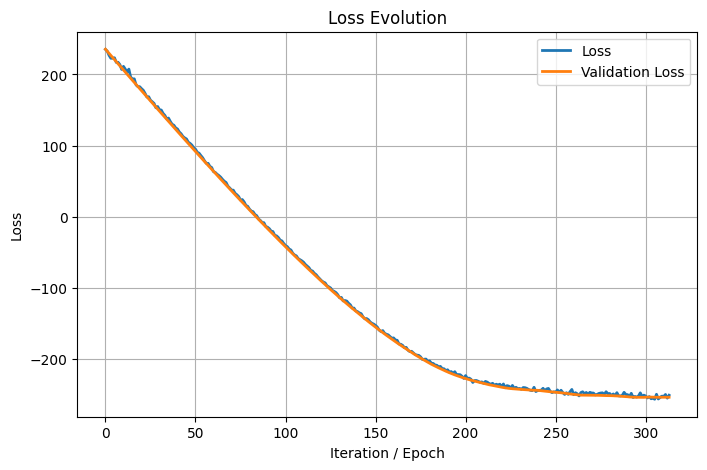

In [10]:
import matplotlib.pyplot as plt
loss_history = output['loss_history']
val_loss = output['val_history']


# Plot            
plt.figure(figsize=(8, 5))
plt.plot(loss_history, label="Loss", linewidth=2)
plt.plot(val_loss, label="Validation Loss", linewidth=2)
plt.xlabel("Iteration / Epoch")
plt.ylabel("Loss")
plt.title("Loss Evolution")
plt.legend()
plt.grid(True)
plt.show()

In [11]:
print(len(output['mu']), sum(p.numel() for p in model.parameters() if p.requires_grad))
print(output['mu'])

150 150
tensor([-9.5665e+00,  1.1688e+00,  1.2207e+00,  1.3243e+00,  1.3589e+00,
         1.9572e+00,  1.3844e+00,  1.2935e+00,  1.7361e+00,  1.6411e+00,
         1.6411e+00,  1.6411e+00, -9.3545e+00,  1.1076e+00,  1.1166e+00,
         1.0239e+00,  1.1016e+00,  1.6219e+00,  1.3629e+00,  1.4243e+00,
         2.1950e+00,  3.0839e+00,  1.6411e+00,  1.6411e+00,  5.6664e-02,
        -2.0305e-02,  1.3780e-03, -3.3479e-02,  5.6059e-02, -4.7629e-03,
        -6.2984e-04,  7.9027e-02, -1.8142e-02,  4.3924e-02, -5.8501e-02,
        -1.3991e-01, -6.4491e-02,  1.3824e-01,  2.4254e-01,  2.0311e-01,
         4.9322e-02,  3.3825e-02, -3.0669e-02, -1.9665e-01, -4.1091e-02,
         1.5378e-01,  2.6188e-01,  2.0716e-01,  1.5586e-01,  1.2589e-01,
         1.8023e-01,  8.7819e-02,  8.8550e-02,  2.4180e-01,  2.1991e-01,
         1.1973e-01,  2.8085e-01,  2.7119e-01,  1.3406e-01, -3.7213e-02,
        -1.2874e-01, -6.3926e-02, -4.3706e-02,  3.5663e-03, -1.5717e-02,
         8.4027e-02,  2.8769e-02, -4.3525e-

In [12]:
import torch

def flat_params(model):
    return torch.cat([p.detach().flatten().cpu() for p in model.parameters()])

# snapshot BEFORE
before = flat_params(model).clone()

model.bayesian_param_set(output, update_buffers=False)
# snapshot AFTER
after = flat_params(model)

max_abs_change = (after - before).abs().max().item()
print(f"Max |Δ| across all parameters: {max_abs_change:.3e}")



Max |Δ| across all parameters: 0.000e+00


In [13]:
# pretrain the marginal transformations
#_ = model.pretrain_transformation_layer(dataloader_train, iterations=1000, max_batches_per_iter=False, penalty_splines_params=penalty_splines_params)

In [14]:
# train the joint model
#_ = model.train(train_dataloader=dataloader_train, validate_dataloader=dataloader_validate, iterations=1000, optimizer="LBFGS",
#                penalty_splines_params=penalty_splines_params, adaptive_lasso_weights_matrix=adaptive_lasso_weights_matrix, penalty_lasso_conditional_independence=penalty_lasso_conditional_independence, 
#                max_batches_per_iter=False)

### 4. Compare to Benchmarks

We compare the learned GTM to a Gaussian Approximation and the Oracle Model. We expect the GTM to lie between these two in terms of approximation the true underlying distribution.
We measure this by means of the Kullback Leibler Divergence which we approximate on the test set which is equivalent to the log likelihood ratio between the true distribution and an approximation of it..

In [15]:
log_likelihood_train_gtm = model.log_likelihood(simulated_data_train)
log_likelihood_validate_gtm = model.log_likelihood(simulated_data_validate)
log_likelihood_test_gtm = model.log_likelihood(simulated_data_test)

In [16]:
# estimate the Multivariate Normal Distribution as Model
mean_mvn_model = simulated_data_train.mean(0)
cov_mvn_model = simulated_data_train.T.cov()
mvn_model = torch.distributions.MultivariateNormal(loc=mean_mvn_model, covariance_matrix=cov_mvn_model)
log_likelihood_train_gaussian = mvn_model.log_prob(simulated_data_train)
log_likelihood_validate_gaussian = mvn_model.log_prob(simulated_data_validate)
log_likelihood_test_gaussian = mvn_model.log_prob(simulated_data_test)


In [17]:
print("KLD GTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gtm).item(),4) )
print("KLD Gaussian Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gaussian).item(),4) )
print("KLD Copula   Train Data: ",np.round(torch.mean(loglik_true_train - loglik_true_est_train).item(),4) )

print("KLD GTM      Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gtm).item(),4) )
print("KLD Gaussian Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gaussian).item(),4) )
print("KLD Copula   Test  Data: ",np.round(torch.mean(loglik_true_test - loglik_true_est_test).item(),4) )

KLD GTM      Train Data:  1.3434
KLD Gaussian Train Data:  0.104
KLD Copula   Train Data:  -0.0001
KLD GTM      Test  Data:  1.3062
KLD Gaussian Test  Data:  0.1145
KLD Copula   Test  Data:  0.0019


### 5. Evaluate and Plot GTM Results

We evaluate the model further by showing how to generate synthetic samples, plot the conditional correlation patterns as well as the model splines.

Note that to generate synthetic samples the inverse of the trainsformation layer needs to be approximated  with the method `approximate_transformation_inverse` once which is then stored for future sampling. 

In [18]:
model.approximate_transformation_inverse()
synthetic_samples = model.sample(10000)

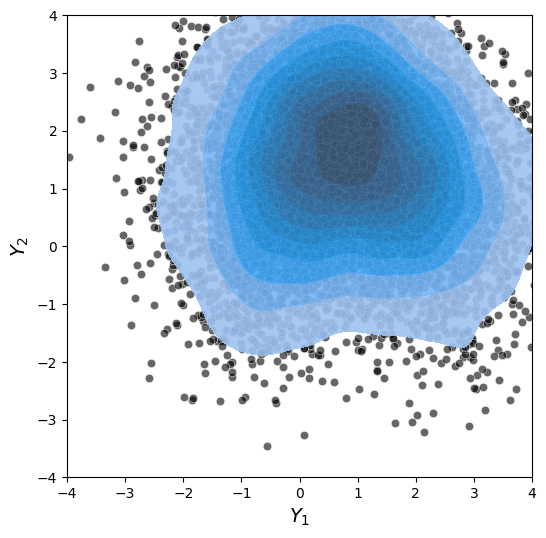

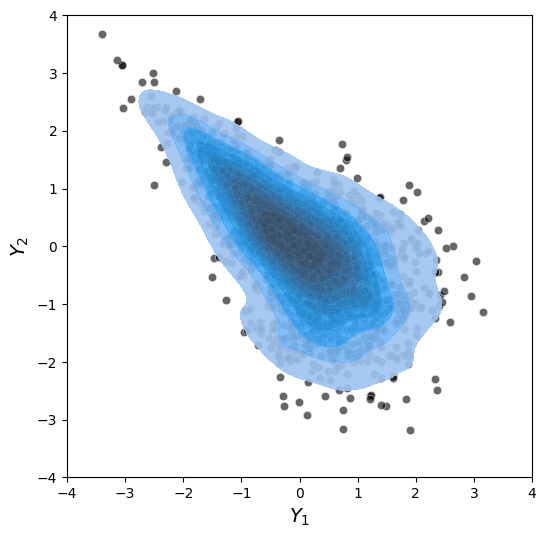

In [19]:
model.plot_densities(synthetic_samples, x_lim=[-4,4], y_lim=[-4,4])
model.plot_densities(simulated_data_train, x_lim=[-4,4], y_lim=[-4,4])

The varying pseudo conditional correlation matrix values can be computed for any synthetic samples using `compute_pseudo_conditional_correlation_matrix` or can directly be plotted using `plot_conditional_dependence_structure`.
The pseudo conditional correlation matrix is the standardised precision matrix so that off diagonal elements are the pseudo conditional correlations between the respective dimensions.

In [20]:
pseudo_conditional_correlation_matrix = model.compute_pseudo_conditional_correlation_matrix(synthetic_samples)

/Users/franciscocapunay/miniforge3/envs/gtm-magic-env-3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/franciscocapunay/miniforge3/envs/gtm-magic-env-3.11/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


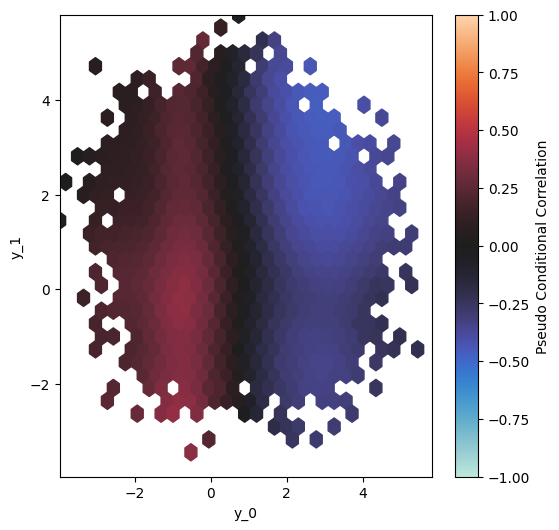

In [21]:
model.plot_conditional_dependence_structure(data=synthetic_samples)

One can also visualize the splines of each layer usign the function `plot_splines`. For the transformation layer we additionally include the dervaitive which is always positive due to the monotonically increasing constraint as well as the inverse which should lie exactly on the spline to visually confirm that the inverse sampling path works.

/Users/franciscocapunay/Documents/AkademischeAusbildungLernunterlagen/UniversitaetGoettingen/Studiengänge/MasterAngewandteStatistik/4.Semester/MA/code/gtm/gtm/gtm_plots_analysis/plot_splines.py:113: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


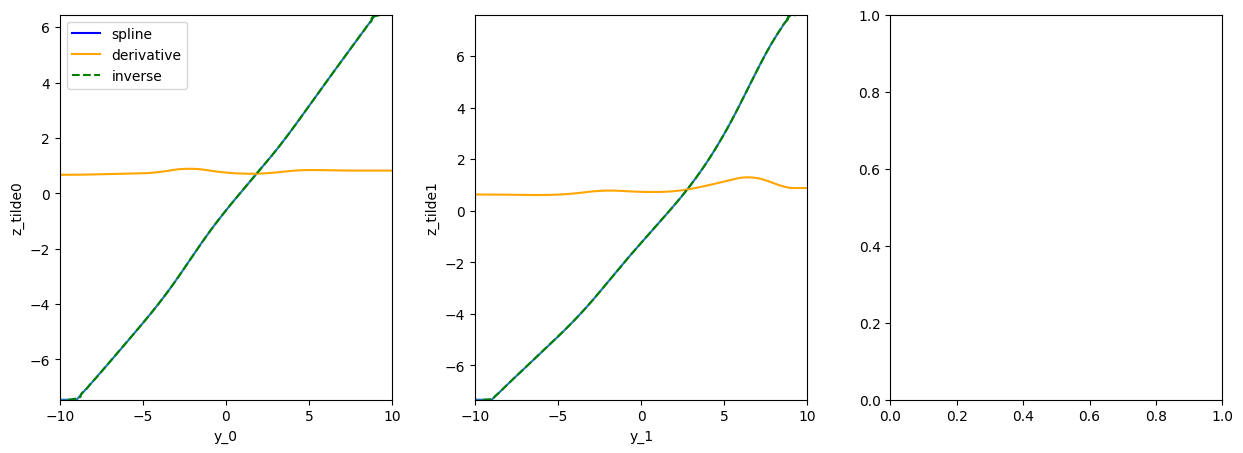

In [22]:
model.plot_splines(layer_type="transformation")

/Users/franciscocapunay/Documents/AkademischeAusbildungLernunterlagen/UniversitaetGoettingen/Studiengänge/MasterAngewandteStatistik/4.Semester/MA/code/gtm/gtm/gtm_plots_analysis/plot_splines.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


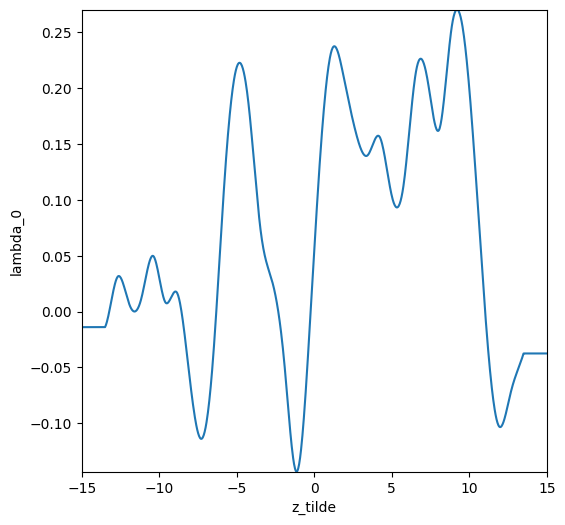

In [23]:
model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=0)

/Users/franciscocapunay/Documents/AkademischeAusbildungLernunterlagen/UniversitaetGoettingen/Studiengänge/MasterAngewandteStatistik/4.Semester/MA/code/gtm/gtm/gtm_plots_analysis/plot_splines.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


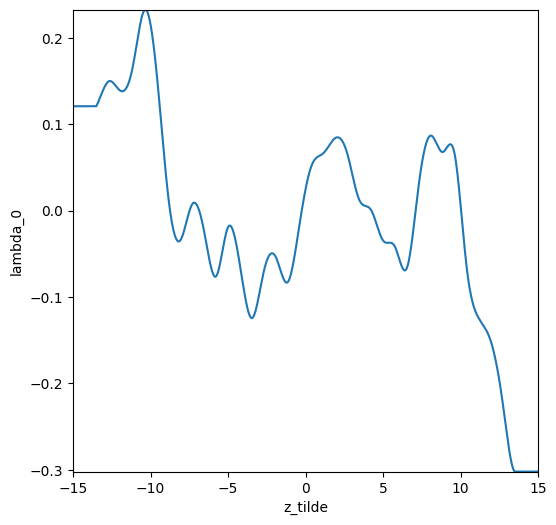

In [24]:
model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=1)

/Users/franciscocapunay/Documents/AkademischeAusbildungLernunterlagen/UniversitaetGoettingen/Studiengänge/MasterAngewandteStatistik/4.Semester/MA/code/gtm/gtm/gtm_plots_analysis/plot_splines.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


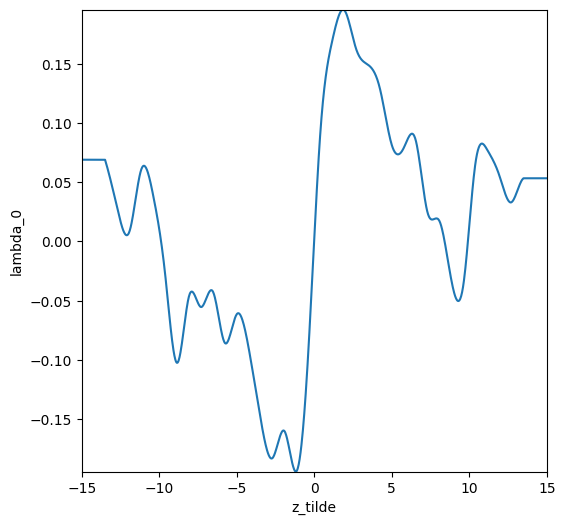

In [25]:
model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=2)